## Transformations
This notebook contains several image-processing transformations, such as Gaussian blur, segmentation masks, bounding boxes, and contour analysis.

## Dependencies

In [38]:
import os
import sys
import cv2
import argparse
import numpy as np
import matplotlib.pyplot as plt

## Load Image

In [39]:
def load_image(image_path):
    """Load an image (and convert from BGR to RGB) using OpenCV."""
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        print(f"Error: Could not read image {image_path}")
        sys.exit(1)
    return cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

## Save Image

In [40]:
def save_image(image, save_path):
    """Save an RGB image to file (convert to BGR first)."""
    img_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(save_path, img_bgr)

## Transformation Original

In [41]:
def transformation_original(image):
    """Return the original image."""
    return image.copy()

## Transformation Gaussian

In [42]:
def transformation_gaussian(image):
    """Apply a Gaussian blur to the image."""
    return cv2.GaussianBlur(image, (7, 7), 0)

## Transformation Mask

In [43]:
def transformation_mask(image):
    """
    Create a binary mask based on HSV thresholds.
    (For example, to roughly segment a green leaf.)
    """
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    lower = np.array([25, 40, 40])
    upper = np.array([95, 255, 255])
    mask = cv2.inRange(hsv, lower, upper)
    mask_rgb = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    return mask_rgb

## Transformation Roi

In [44]:
def transformation_roi(image):
    """
    Find contours from the mask and draw bounding boxes (ROIs)
    on the image.
    """
    mask = cv2.cvtColor(transformation_mask(image), cv2.COLOR_RGB2GRAY)
    contours, _ = cv2.findContours(
        mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    image_roi = image.copy()
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(image_roi, (x, y), (x + w, y + h), (0, 0, 255), 2)
    return image_roi

## Transformation Analyze

In [45]:
def transformation_analyze(image):
    """
    Find the largest contour, compute its area and perimeter,
    and annotate the image.
    """
    mask = cv2.cvtColor(transformation_mask(image), cv2.COLOR_RGB2GRAY)
    contours, _ = cv2.findContours(
        mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    image_analyze = image.copy()
    if contours:
        largest = max(contours, key=cv2.contourArea)
        area = cv2.contourArea(largest)
        perimeter = cv2.arcLength(largest, True)
        cv2.drawContours(image_analyze, [largest], -1, (0, 255, 0), 2)
        cv2.putText(image_analyze, f"Area: {int(area)}", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)
        cv2.putText(image_analyze, f"Perimeter: {int(perimeter)}", (10, 60),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)
    return image_analyze

## Transformation Pseudolandmarks

In [46]:
def transformation_pseudolandmarks(image):
    """
    Detect corners (pseudolandmarks) using goodFeaturesToTrack and mark them.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    corners = cv2.goodFeaturesToTrack(
        gray, maxCorners=50, qualityLevel=0.01, minDistance=10)
    image_landmarks = image.copy()
    if corners is not None:
        corners = corners.astype(int)
        for i in corners:
            x, y = i.ravel()
            cv2.circle(image_landmarks, (x, y), 3,
                       (255, 0, 255), -1)
    return image_landmarks

## Plot Color Histogram

In [47]:
def plot_color_histogram(image, ax):
    """Plot the color histogram (for each channel) on the provided axis."""
    colors = ('r', 'g', 'b')
    for i, col in enumerate(colors):
        hist = cv2.calcHist([image], [i], None, [256], [0, 256])
        ax.plot(hist, color=col)
        ax.set_xlim([0, 256])
    ax.set_title("Color Histogram")

## Process Image

In [48]:
def process_image(image_path):
    """Load an image and compute all transformations."""
    image = load_image(image_path)
    transformations = {
        "Original": transformation_original(image),
        "Gaussian_blur": transformation_gaussian(image),
        "Mask": transformation_mask(image),
        "ROI_objects": transformation_roi(image),
        "Analyze_object": transformation_analyze(image),
        "Pseudolandmarks": transformation_pseudolandmarks(image)
    }
    return image, transformations

## Display Transformations

In [49]:
def display_transformations(image, transformations):
    """
    Display all seven figures (six transformations plus color histogram)
    in one matplotlib window.
    """
    fig = plt.figure(figsize=(12, 10))
    titles = [
        "Figure IV.1: Original",
        "Figure IV.2: Gaussian blur",
        "Figure IV.3: Mask",
        "Figure IV.4: ROI objects",
        "Figure IV.5: Analyze object",
        "Figure IV.6: Pseudolandmarks",
        "Figure IV.7: Color histogram"
    ]

    trans_order = [
        transformations["Original"],
        transformations["Gaussian_blur"],
        transformations["Mask"],
        transformations["ROI_objects"],
        transformations["Analyze_object"],
        transformations["Pseudolandmarks"]
    ]

    for i, img in enumerate(trans_order):
        ax = fig.add_subplot(3, 3, i + 1)
        ax.imshow(img)
        ax.set_title(titles[i])
        ax.axis('off')

    ax = fig.add_subplot(3, 3, 7)
    plot_color_histogram(image, ax)
    ax.axis('on')

    plt.tight_layout()
    plt.show()

## Save Transformations

In [50]:
def save_transformations(image_path, dst_dir):
    """
    Process one image and save the resulting transformations in the
    destination directory. The color histogram is saved as a PNG.
    """
    try:
        import matplotlib.pyplot as plt
    except ImportError:
        print("Matplotlib or NumPy not available. Skipping histogram save.")

        image, transformations = process_image(image_path)
        base_name = os.path.splitext(os.path.basename(image_path))[0]
        os.makedirs(dst_dir, exist_ok=True)
        for name, img in transformations.items():
            save_path = os.path.join(dst_dir, f"{base_name}_{name}.jpg")
            save_image(img, save_path)
            print(f"Saved: {save_path}")
        return

    image, transformations = process_image(image_path)
    base_name = os.path.splitext(os.path.basename(image_path))[0]

    os.makedirs(dst_dir, exist_ok=True)

    for name, img in transformations.items():
        save_path = os.path.join(dst_dir, f"{base_name}_{name}.jpg")
        save_image(img, save_path)
        print(f"Saved: {save_path}")

    hist_path = os.path.join(dst_dir, f"{base_name}_Color_histogram.png")
    fig, ax = plt.subplots()
    plot_color_histogram(image, ax)
    plt.savefig(hist_path)
    plt.close(fig)
    print(f"Saved: {hist_path}")

## Process Directory

In [51]:
def process_directory(src_dir, dst_dir):
    """
    Process all image files in the source directory and save the
    transformations to the destination directory.
    """
    valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff'}
    for entry in os.scandir(src_dir):
        if entry.is_file() and os.path.splitext(
                entry.name)[1].lower() in valid_extensions:
            save_transformations(entry.path, dst_dir)

## Display Saved Images

In [52]:
def display_saved_images(output_dir):
    """Display saved images filtering by valid image extensions."""
    from IPython.display import display, Image
    import glob, os

    valid_exts = {'.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff'}
    paths = glob.glob(os.path.join(output_dir, '*'))
    img_paths = sorted([p for p in paths
                        if os.path.isfile(p) and os.path.splitext(p)[1].lower() in valid_exts])

    for img_path in img_paths:
        display(Image(filename=img_path))

## Main Program

In [53]:
def main():
    """Main program to process images and display transformations."""
    extract_path = 'image1.JPG'
    dst = '/content'

    if os.path.isdir(extract_path):
        process_directory(extract_path, dst)
    elif os.path.isfile(extract_path):
        save_transformations(extract_path, dst)
    else:
        print(f"Error: {extract_path} is not a valid file or directory.")

    display_saved_images(dst)

## Run Main

Saved: /content/image1_Original.jpg
Saved: /content/image1_Gaussian_blur.jpg
Saved: /content/image1_Mask.jpg
Saved: /content/image1_ROI_objects.jpg
Saved: /content/image1_Analyze_object.jpg
Saved: /content/image1_Pseudolandmarks.jpg
Saved: /content/image1_Color_histogram.png


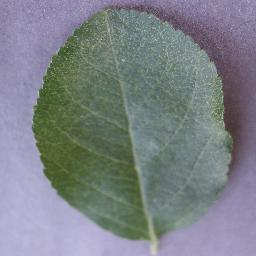

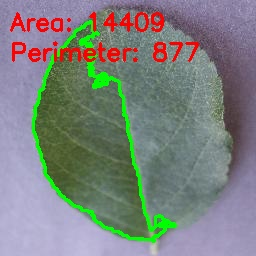

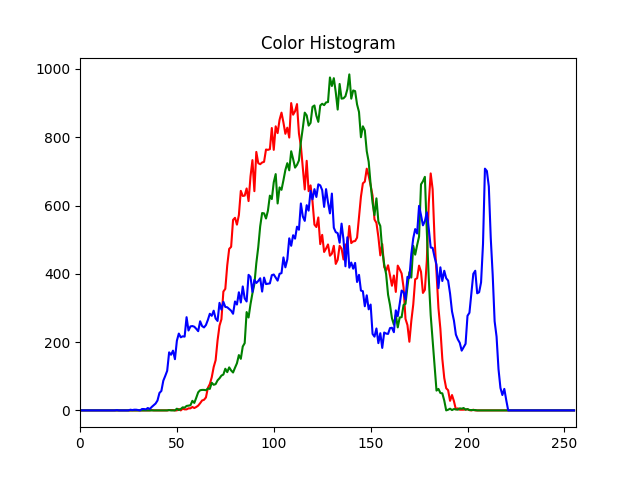

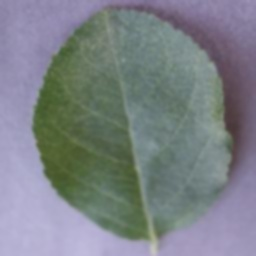

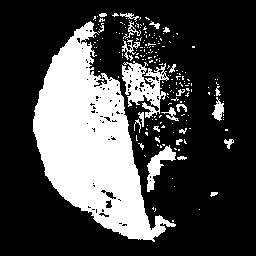

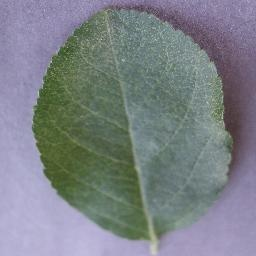

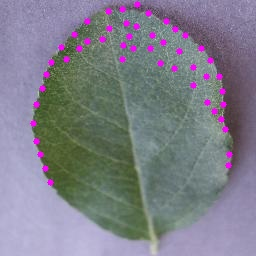

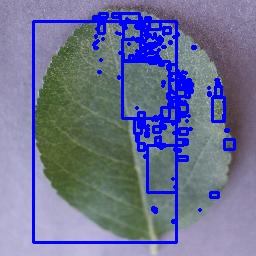

In [54]:
main()

## Cleanup

In [55]:
# ! rm image1_*.*